In [1]:
import time
import warnings
import math as m

import cvxpy as cp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from numpy import linalg
from numpy.linalg import matrix_rank
from scipy.integrate import solve_ivp
from scipy.linalg import block_diag

# Configure warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

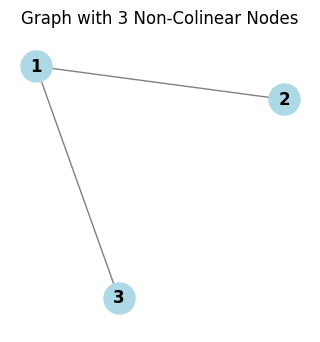

The second smallest eigenvalue of the Laplacian matrix: 1.0
Number of edges: 2


In [2]:
Graph = nx.Graph()
Graph.add_edges_from([(1, 2), (1, 3)])  # 3 nodes, 2 edges

# Calculate positions of 3 nodes forming an equilateral triangle
angle = np.pi / 2
positions = {
    1: (0, 0),        # Node 1: far left
    2: (1.5, -0.2),   # Node 2: right side, aligned horizontally
    3: (0.5, -1.4),}  # Node 3: below, between nodes 1 and 2

# Draw the graph
plt.figure(figsize=(3, 3))
nx.draw(Graph, positions, with_labels=True, node_color='lightblue',
        node_size=500, edge_color='gray', font_weight='bold')
plt.title("Graph with 3 Non-Colinear Nodes")
plt.axis("equal")
plt.show()

n_nodes = Graph.number_of_nodes()
m_edges = Graph.number_of_edges()

L = nx.laplacian_matrix(Graph).todense()

#Eigenvalue of L
eigvals = np.linalg.eigvals(L)
eigvals = np.sort(np.real(eigvals))

#Second smallest eigenvalue of L
lambda_2 = round(eigvals[1], 4)

print(f'The second smallest eigenvalue of the Laplacian matrix: {lambda_2}')
print(f'Number of edges: {m_edges}')

In [3]:
#Create a lexically oriented incidence matrix of the above Graph.
edges = [(min(u, v), max(u, v)) for u, v in Graph.edges()]

edges.sort()

num_edges = len(edges)
Theta = np.zeros((n_nodes, num_edges))

for e_idx, (u, v) in enumerate(edges):
    Theta[u - 1, e_idx] = 1
    Theta[v - 1, e_idx] = -1

In [4]:
###Create the agents
#Parameters in nominal vector field
a1 = 0.4
a2 = 10
a3 = np.pi/2

#Matrix B and \bar{B}
B = np.array([[1]])
B_bar = np.kron(np.eye(n_nodes),B)

#Matrix C and \bar{C}
C = np.array([[1]])
C_bar = np.kron(np.eye(n_nodes), C)

#Matrix \bar{D}
d1 = 0
d2 = 1
d3 = 1
D_bar = block_diag(d1, d2, d3)

#Parameters for pertubations
gamma1 = -0.1 ; gamma2 = 0.2 ; gamma3 = -0.2

In [5]:
###Create all couplings in the form of Lemma 4
#Matrix W'
W_l = 1
W = block_diag(*[W_l]*m_edges)

#Matrix H'
H_l = np.array([[2, -1]])
H = block_diag(*[H_l]*m_edges)

#Matrix N'
N_l = np.array([[2], [-1]])
N = block_diag(*[N_l]*m_edges)

#Matrix M'
M_l = np.array([[-1,0],[0,0.5]])
M = block_diag(*[M_l]*m_edges)

#Vector r'
r_l = np.array([[2],[-2]])
r = np.vstack([r_l for _ in range(m_edges)])

#Matrix Xi, Xi^-1
Xi = np.eye(m_edges) + W@Theta.T@D_bar@Theta
Xi_inv = np.linalg.inv(Xi)

#Matrix Delta, Delta^-1
Delta = np.eye(m_edges) + Theta.T@D_bar@Theta@W
Delta_inv = np.linalg.inv(Delta)

#Matrix Gamma'
Gamma = M + N@Theta.T@D_bar@Theta@Xi_inv@H

In [6]:
###Create parameters for numerical simulation
#Initial state x0
x0 = np.array([[4],[1],[-2]])

#Time-step h
h = 0.01

R = np.eye(n_nodes)
Rinv = R

#Matrix in step 1
Matrix_1 = B_bar@Theta@Xi_inv@W@Theta.T@C_bar

##Matrix in step 2
G = N@Delta_inv@Theta.T@C_bar@Rinv
Matrix_2 = Gamma + h*G@G.T

#Matrix in step 3
Matrix_3 = Theta@Xi_inv@W@Theta.T@C_bar
Matrix_4 = Theta@Xi_inv@H

In [7]:
#Number of iterations
n_inter = 1000

X = np.zeros((n_nodes, n_inter))     #State
T = []                                 #Time
U = np.zeros((n_nodes, n_inter))       #Input

xk = x0
step_times = []
total_start = time.perf_counter()

h_z = np.zeros((2*m_edges, 1))
x_bar = cp.Variable((2*m_edges, 1))

#Constraint
constraints = [x_bar >= 0]

zk_bar_param = cp.Parameter((G.shape[1], 1))
#Objective function
obj = cp.quad_form(x_bar, cp.psd_wrap(Matrix_2)) + 2*(r + G@zk_bar_param).T@x_bar

problem = cp.Problem(cp.Minimize(obj), constraints)
for k in range(0,n_inter):
  t = k*h
  step_start = time.perf_counter()

  #Matrix A(t)
  A = np.array([[a1*np.cos(a2*t + a3)]])
  At = np.kron(np.eye(n_nodes), A)

  #zk_bar
  Fnom = At@xk
  zk_bar = R@(xk + h*Fnom - h*Matrix_1@xk)

  #Optimal variable
  x_bar.value = h_z
  zk_bar_param.value = zk_bar

  #problem.solve(solver=cp.OSQP, eps_abs=1e-10, eps_rel=1e-10, max_iter=10000, warm_start=True)
  problem.solve(solver=cp.OSQP, warm_start=True)

  #Result of the control input u_k
  h_z = x_bar.value
  uk = -Matrix_3@xk + Matrix_4@h_z

  step_end = time.perf_counter()
  elapsed = step_end - step_start
  step_times.append(elapsed)

  #Update X, T, U
  X[:,k] = xk[:,0]
  T = np.append(T,t)
  U[:, k] = uk[:,0]

  #Pertubations \bar{xi}
  xi = np.zeros((n_nodes,1))
  xi[0,0] = gamma1*m.sin(t*xk[0]+1)*m.cos(t*xk[1]-xk[2])
  xi[1,0] = gamma2*m.sin(20*t*xk[0]+xk[1])*m.cos(3*t*xk[1]*xk[2]-1)
  xi[2,0] = gamma3*m.sin(12*t*xk[2])*m.cos(2*t*xk[0])

  #Update x_k (i.e. compute x_{k+1})
  xk = xk + h*(Fnom + B_bar@uk) + h*B_bar@xi

total_end = time.perf_counter()
print(f"Total execution time: {total_end - total_start:.6f} seconds")

Total execution time: 2.202322 seconds


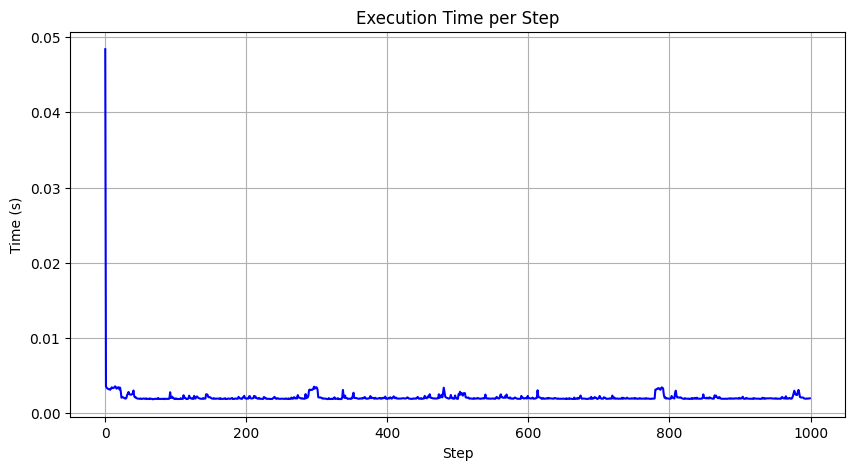

In [8]:
# Plot the execution time of each step
plt.figure(figsize=(10, 5))
plt.plot(range(n_inter), step_times, color='blue')
plt.xlabel('Step')
plt.ylabel('Time (s)')
plt.title('Execution Time per Step')
plt.grid(True)
plt.show()

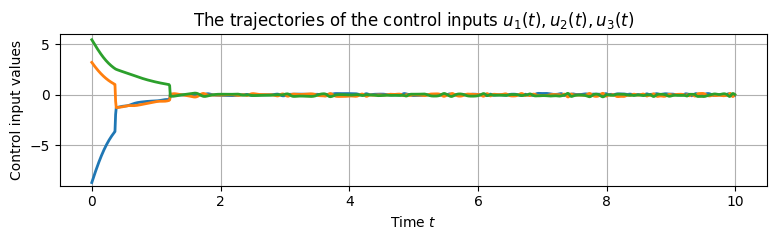

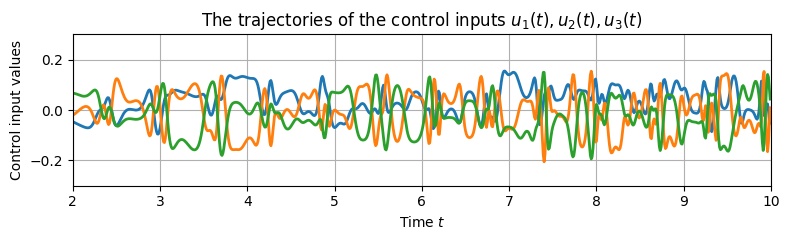

/tmp/ipython-input-940158787.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


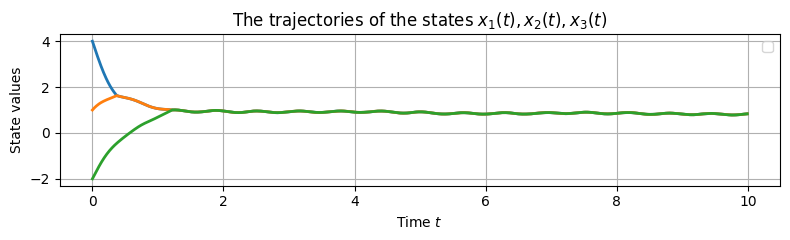

In [9]:
#Plot the input u(t)
plt.figure(figsize=(8, 2.5))
for i in range(n_nodes):
  plt.plot(T, U[i,:], linewidth=2)

plt.xlabel('Time $t$')
plt.ylabel('Control input values')
plt.title('The trajectories of the control inputs $u_1(t), u_2(t), u_{3}(t)$')
plt.grid(True)
plt.ylim(-9,6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 2.5))
for i in range(n_nodes):
  plt.plot(T, U[i,:], linewidth=2)

plt.xlabel('Time $t$')
plt.ylabel('Control input values')
plt.title('The trajectories of the control inputs $u_1(t), u_2(t), u_{3}(t)$')
plt.grid(True)
plt.xlim(2,10)
plt.ylim(-0.3,0.3)
plt.tight_layout()
plt.show()

#Plot the state x(t)
plt.figure(figsize=(8, 2.5))
for i in range(0,n_nodes):
  plt.plot(T, X[i,:], linewidth=2)

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('The trajectories of the states $x_1(t), x_2(t), x_{3}(t)$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

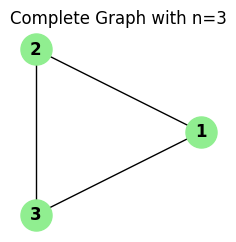

In [10]:
###Compute Error state e(t) = (Theta_c.T \otimes I_2)x(t) and its norm.
Graph_complete = nx.complete_graph(n_nodes)

mapping_complete = {i: i + 1 for i in Graph_complete.nodes()}
Graph_complete = nx.relabel_nodes(Graph_complete, mapping_complete)

pos = nx.circular_layout(Graph_complete)
plt.figure(figsize=(2, 2))
nx.draw(Graph_complete, pos, node_color='lightgreen', node_size=500, edge_color='black', with_labels=True, font_weight='bold')
plt.title(f'Complete Graph with n={n_nodes}')
plt.show()

#Create an oriented incidence matrix of the complete Graph corresponding to the above Graph.
edges_complete = []
for u, v in Graph_complete.edges():
  if u > v:
    edges_complete.append((u, v))
  else:
    edges_complete.append((v, u))

num_edges_complete = len(edges_complete)
Theta_c = np.zeros((n_nodes, num_edges_complete))

for e_idx, (u, v) in enumerate(edges_complete):
    # Subtract 1 from u and v to adjust for 0-based indexing in NumPy
    Theta_c[u - 1, e_idx] = -1
    Theta_c[v - 1, e_idx] = +1

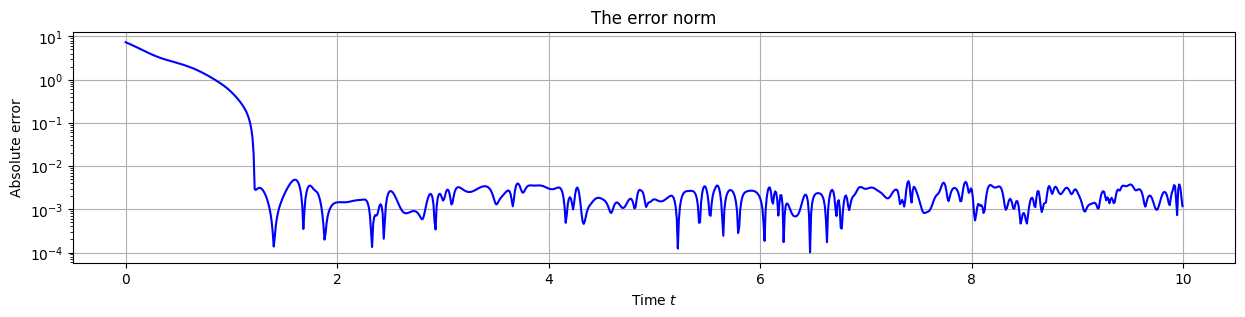

In [11]:
###Draw the error norm
E = np.kron(Theta_c.T, np.eye(1)) @ X  # shape: (time_steps, new_dim)
e = np.linalg.norm(E, axis=0)

plt.figure(figsize=(15, 3))
plt.plot(T, e, color='blue')
plt.yscale('log')
plt.xlabel('Time $t$')
plt.ylabel('Absolute error')
plt.title('The error norm')
plt.grid()
plt.show()